In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from utils import prepare_cifar10_data
from models import Generator, Discriminator, weights_init, calculate_fretchet

In [ ]:
# Training settings
torch.manual_seed(42)
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 70
g_lr = 0.0001
d_lr = 0.0004
beta1 = 0.5
ngpu = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0,0,0), (1,1,1)),])


dataloader, _, _ = prepare_cifar10_data(transform, batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


Starting Training Loop...
[5/70]	Loss_D: 2.4049	Loss_G: 6.9701	Fretchet_Distance: 214.1011


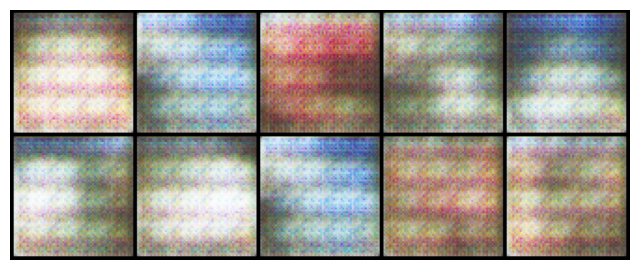

[10/70]	Loss_D: 0.6583	Loss_G: 3.1290	Fretchet_Distance: 133.5099


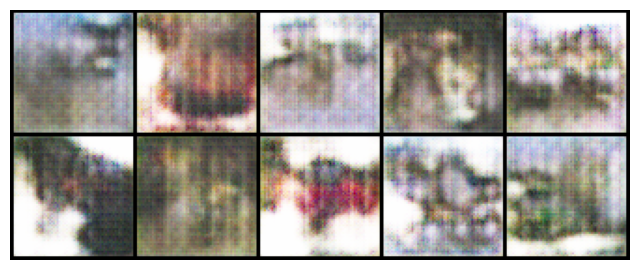

[15/70]	Loss_D: 0.4680	Loss_G: 2.4453	Fretchet_Distance: 131.5164


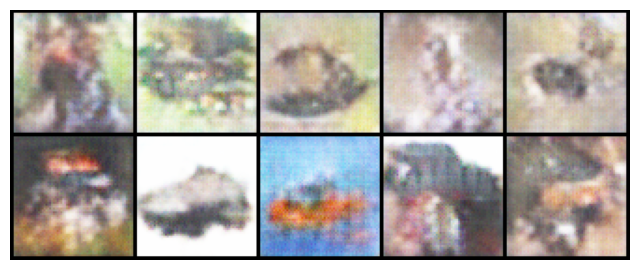

[20/70]	Loss_D: 0.6673	Loss_G: 2.4066	Fretchet_Distance: 133.6404


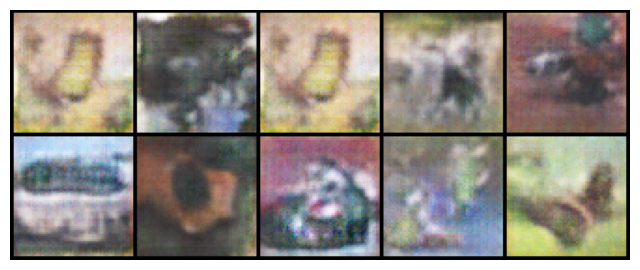

[25/70]	Loss_D: 0.9678	Loss_G: 2.5343	Fretchet_Distance: 126.0698


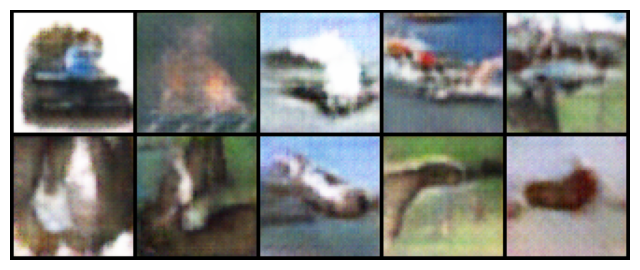

[30/70]	Loss_D: 0.4377	Loss_G: 4.2968	Fretchet_Distance: 128.9767


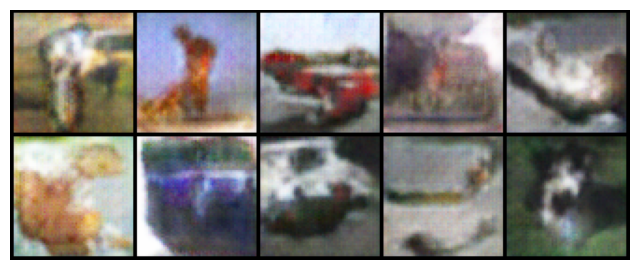

[35/70]	Loss_D: 0.4988	Loss_G: 3.8522	Fretchet_Distance: 133.3098


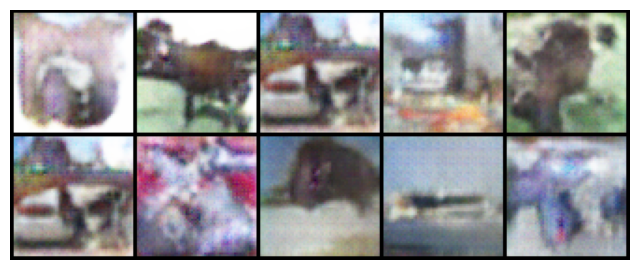

[40/70]	Loss_D: 0.3919	Loss_G: 3.5176	Fretchet_Distance: 125.9115


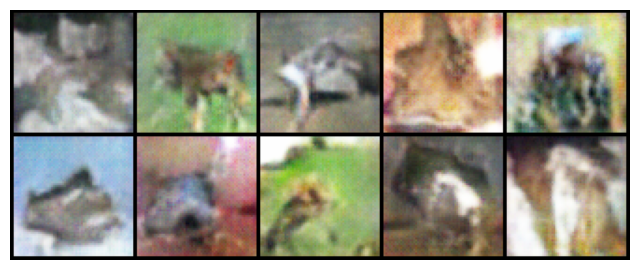

[45/70]	Loss_D: 0.7422	Loss_G: 5.7126	Fretchet_Distance: 131.2429


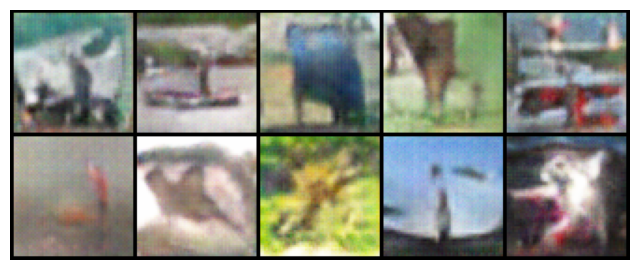

[50/70]	Loss_D: 0.7112	Loss_G: 1.8687	Fretchet_Distance: 125.9323


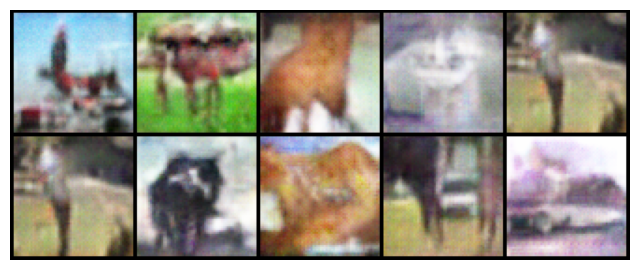

[55/70]	Loss_D: 0.6121	Loss_G: 1.2319	Fretchet_Distance: 119.9869


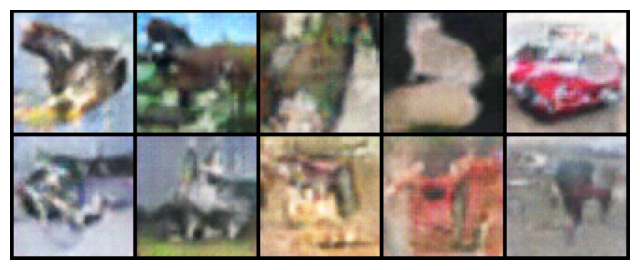

[60/70]	Loss_D: 0.3713	Loss_G: 3.2264	Fretchet_Distance: 127.4791


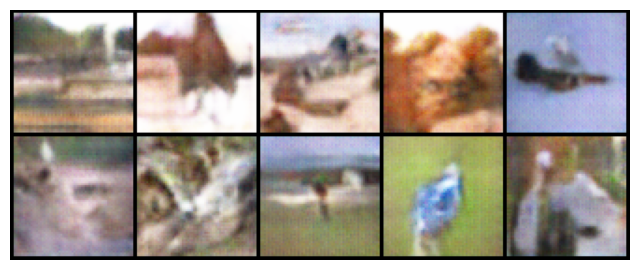

[65/70]	Loss_D: 0.3859	Loss_G: 3.0689	Fretchet_Distance: 127.8563


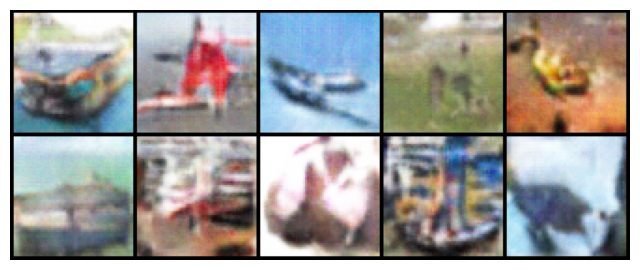

[70/70]	Loss_D: 0.4957	Loss_G: 2.4990	Fretchet_Distance: 126.5628


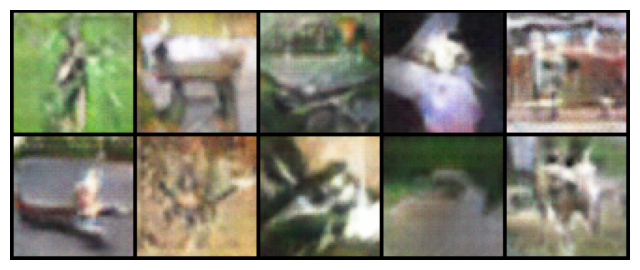

In [64]:
# Create the generator and discriminator
netG = Generator(ngpu, nc, nz, ngf).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu, nc, ndf).to(device)
netD.apply(weights_init)

# Load the pretrained InceptionV3 model and create a feature extractor
inception_model = models.inception_v3(pretrained=True, transform_input=False)
# We use the final pooling layer 'avgpool' for feature extraction
feature_extractor = create_feature_extractor(inception_model, {'avgpool': 'pool'})
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

# Placeholder for real and fake labels
real_label = 1.
fake_label = 0.

# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # Assuming 'dataloader' is defined and provides real images
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Add noise to real images
        real_cpu = 0.9 * real_cpu + 0.1 * torch.randn_like(real_cpu, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        # Add noise to fake images
        fake = 0.9 * fake + 0.1 * torch.randn_like(fake, device=device)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        # Update D
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Reverse labels for generator training
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Save generated images for visualization
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))

        iters += 1

    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Calculate FID
    fretchet_dist = calculate_fretchet(real_cpu, fake, feature_extractor, cuda=True)

    if (epoch + 1) % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f' %
              (epoch + 1, num_epochs, errD.item(), errG.item(), fretchet_dist))
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        idx = torch.randint(len(fake_display), (10,))
        pictures = vutils.make_grid(fake_display[idx], nrow=5, padding=2, normalize=True)
        plt.imshow(np.transpose(pictures, (1, 2, 0)))
        plt.show()

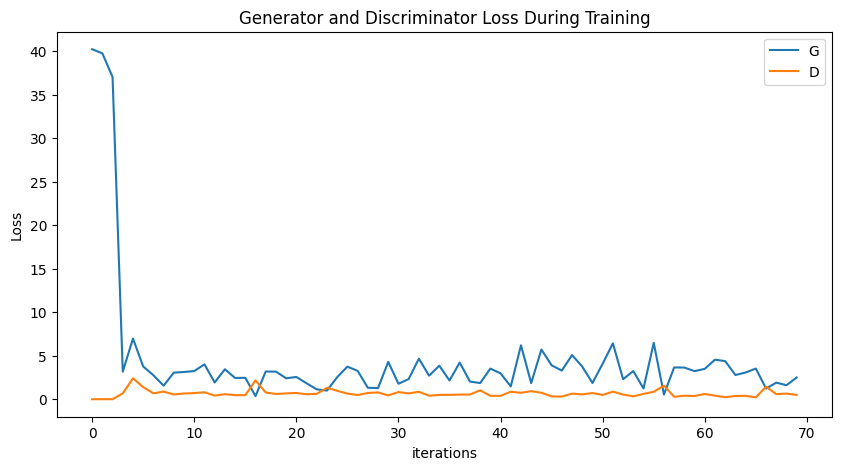

In [65]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

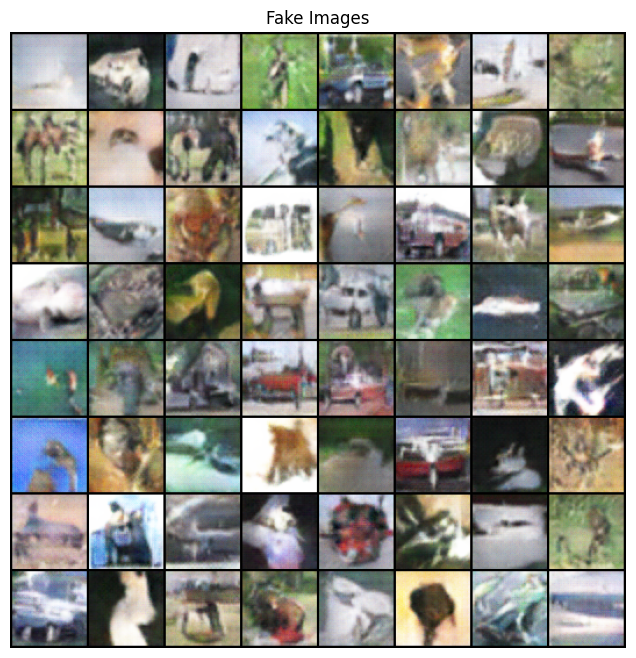

In [66]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()